In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
from collections import Counter

# Set plot styling
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

In [4]:
# Load the data
df = pd.read_csv('pr_analysis_data_open_and_close.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nColumn names:")
print(df.columns.tolist())

# Check first few rows
df.head(3)

Dataset shape: (1025, 16)

Column names:
['repository', 'pr_number', 'title', 'url', 'state', 'merged_at', 'review_comments_count', 'issue_comments_count', 'all_comments', 'year', 'month', 'year_month', 'total_comments', 'category', 'dependency_info', 'change_request_categories']


,repository,pr_number,title,url,state,merged_at,review_comments_count,issue_comments_count,all_comments,year,month,year_month,total_comments,category,dependency_info,change_request_categories
0,jboss/jboss-parent-pom,399,Bump com.puppycrawl.tools:checkstyle from 10.2...,https://github.com/jboss/jboss-parent-pom/pull...,closed,2025-03-05 14:21:39+00:00,0,0,[],2025.0,3.0,2025-03,0,Dependency Updates,{'dependency': 'com.puppycrawl.tools:checkstyl...,{}
1,jboss/jboss-parent-pom,398,Bump org.apache.maven.plugins:maven-install-pl...,https://github.com/jboss/jboss-parent-pom/pull...,closed,2025-02-28 12:48:55+00:00,0,0,[],2025.0,2.0,2025-02,0,Dependency Updates,{'dependency': 'org.apache.maven.plugins:maven...,{}
2,jboss/jboss-parent-pom,397,Bump org.apache.maven.plugins:maven-deploy-plu...,https://github.com/jboss/jboss-parent-pom/pull...,closed,2025-02-27 12:44:29+00:00,0,0,[],2025.0,2.0,2025-02,0,Dependency Updates,{'dependency': 'org.apache.maven.plugins:maven...,{}


PR merge status distribution:
is_merged
1    860
0    165
Name: count, dtype: int64
Merge rate: 83.9%


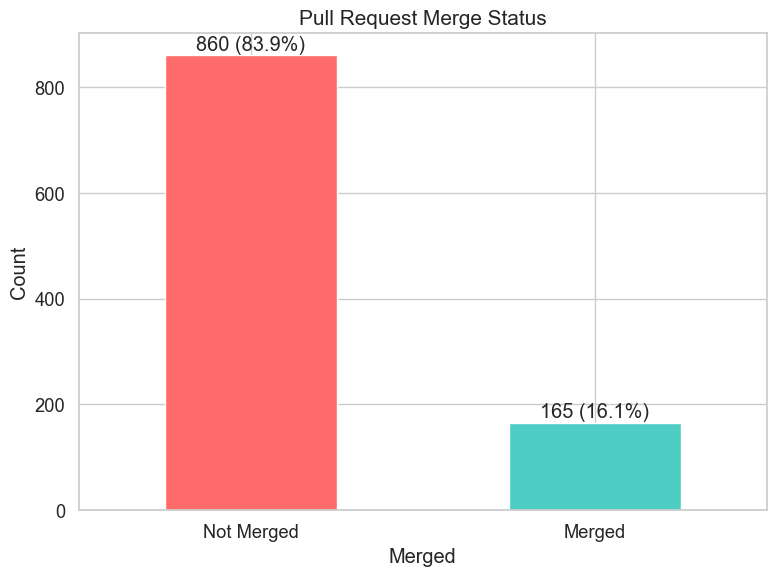

In [5]:
# Add a merged flag for easier analysis
df['is_merged'] = df['merged_at'].notna().astype(int)

# Display the distribution of merged vs non-merged PRs
merge_status = df['is_merged'].value_counts()
print("PR merge status distribution:")
print(merge_status)
print(f"Merge rate: {merge_status[1]/len(df)*100:.1f}%")

# Plot merge status distribution
plt.figure(figsize=(8, 6))
ax = merge_status.plot(kind='bar', color=['#FF6B6B', '#4ECDC4'])
plt.title('Pull Request Merge Status', fontsize=15)
plt.xlabel('Merged')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Merged', 'Merged'], rotation=0)

# Add count labels
for i, count in enumerate(merge_status):
    plt.text(i, count + 10, f"{count} ({count/len(df)*100:.1f}%)", ha='center')

plt.tight_layout()
plt.show()


Comment statistics:
Total review comments: 335
Total issue comments: 1163
Total comments (all types): 1498

PRs with any comments: 463 (45.2%)
PRs with review comments: 81 (7.9%)
PRs with issue comments: 451 (44.0%)


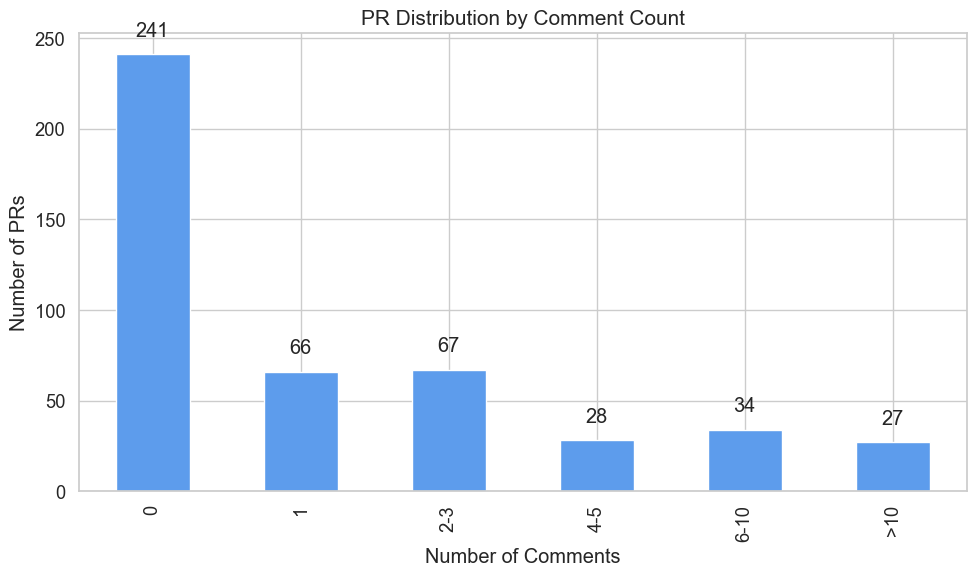

In [7]:
# Analyze comment counts
print("\nComment statistics:")
print(f"Total review comments: {df['review_comments_count'].sum()}")
print(f"Total issue comments: {df['issue_comments_count'].sum()}")
print(f"Total comments (all types): {df['total_comments'].sum()}")

print(f"\nPRs with any comments: {(df['total_comments'] > 0).sum()} ({(df['total_comments'] > 0).sum()/len(df)*100:.1f}%)")
print(f"PRs with review comments: {(df['review_comments_count'] > 0).sum()} ({(df['review_comments_count'] > 0).sum()/len(df)*100:.1f}%)")
print(f"PRs with issue comments: {(df['issue_comments_count'] > 0).sum()} ({(df['issue_comments_count'] > 0).sum()/len(df)*100:.1f}%)")

# Visualize comment distribution
comment_bins = [0, 1, 2, 4, 6, 10, df['total_comments'].max()]
comment_labels = ['0', '1', '2-3', '4-5', '6-10', '>10']
comment_counts = pd.cut(df['total_comments'], bins=comment_bins, labels=comment_labels)

plt.figure(figsize=(10, 6))
comment_dist = comment_counts.value_counts().sort_index()
ax = comment_dist.plot(kind='bar', color='#5D9CEC')
plt.title('PR Distribution by Comment Count', fontsize=15)
plt.xlabel('Number of Comments')
plt.ylabel('Number of PRs')

# Add count labels
for i, count in enumerate(comment_dist):
    plt.text(i, count + 10, str(count), ha='center')

plt.tight_layout()
plt.show()

Merge rates by comment type:
                      Total PRs  Merge Rate (%)
comment_type                                   
Only Review Comments         12      100.000000
No Comments                 562       95.195730
More Review Comments         29       86.206897
Equal Comments                7       85.714286
More Issue Comments          33       81.818182
Only Issue Comments         382       66.753927


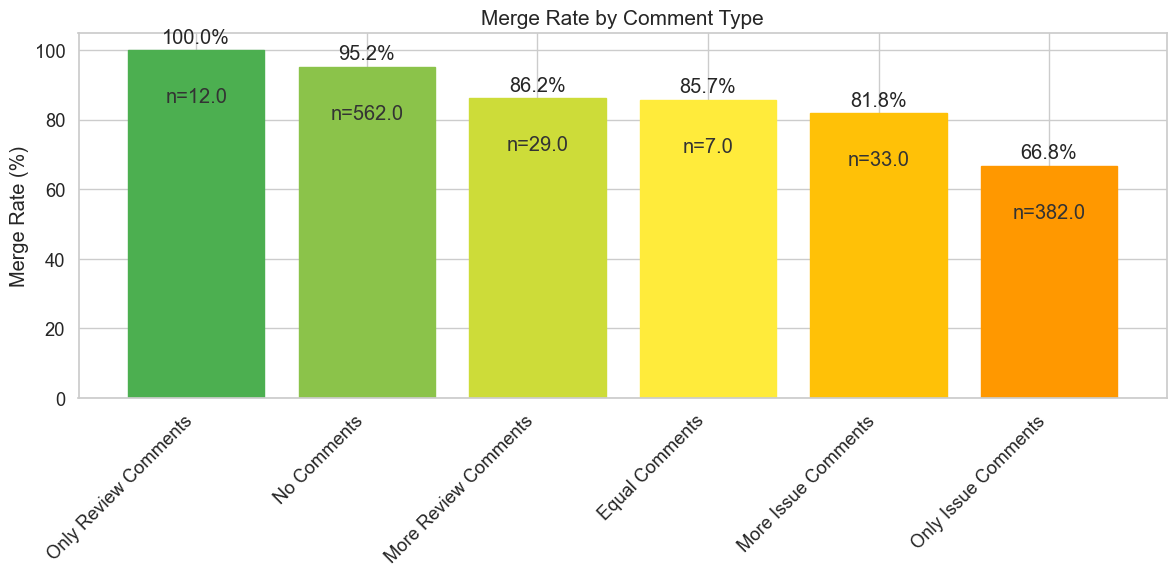

In [8]:
# Create a function to categorize PRs by comment type
def categorize_comment_type(row):
    review_count = row['review_comments_count'] or 0
    issue_count = row['issue_comments_count'] or 0
    
    if review_count == 0 and issue_count == 0:
        return 'No Comments'
    elif review_count > 0 and issue_count == 0:
        return 'Only Review Comments'
    elif review_count == 0 and issue_count > 0:
        return 'Only Issue Comments'
    elif review_count > issue_count:
        return 'More Review Comments'
    elif review_count < issue_count:
        return 'More Issue Comments'
    else:
        return 'Equal Comments'

# Add comment type to dataframe
df['comment_type'] = df.apply(categorize_comment_type, axis=1)

# Calculate merge rates by comment type
merge_by_comment_type = df.groupby('comment_type')['is_merged'].agg(['count', 'mean'])
merge_by_comment_type['mean'] = merge_by_comment_type['mean'] * 100  # Convert to percentage
merge_by_comment_type.columns = ['Total PRs', 'Merge Rate (%)']
merge_by_comment_type = merge_by_comment_type.sort_values('Merge Rate (%)', ascending=False)

print("Merge rates by comment type:")
print(merge_by_comment_type)

# Visualize merge rates by comment type
plt.figure(figsize=(12, 6))
bars = plt.bar(merge_by_comment_type.index, merge_by_comment_type['Merge Rate (%)'])

# Color bars by merge rate
colors = ['#4CAF50', '#8BC34A', '#CDDC39', '#FFEB3B', '#FFC107', '#FF9800']
for i, bar in enumerate(bars):
    bar.set_color(colors[i % len(colors)])

plt.title('Merge Rate by Comment Type', fontsize=15)
plt.ylabel('Merge Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 105)  # Leave room for text

# Add percentage labels
for i, (idx, row) in enumerate(merge_by_comment_type.iterrows()):
    plt.text(i, row['Merge Rate (%)'] + 2, f"{row['Merge Rate (%)']:.1f}%", ha='center')
    plt.text(i, row['Merge Rate (%)'] - 15, f"n={row['Total PRs']}", ha='center', color='#333')

plt.tight_layout()
plt.show()

/var/folders/d4/ty69bjsn50g69q8m4f9_yh8w0000gn/T/ipykernel_38001/849148641.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merge_by_comment_count = df.groupby('comment_count_bin')['is_merged'].agg(['count', 'mean'])


Merge rates by comment count:
                   Total PRs  Merge Rate (%)
comment_count_bin                           
0                        241       67.634855
1                         66       68.181818
2-3                       67       73.134328
4-5                       28       82.142857
6-10                      39       76.923077
>10                       22       68.181818


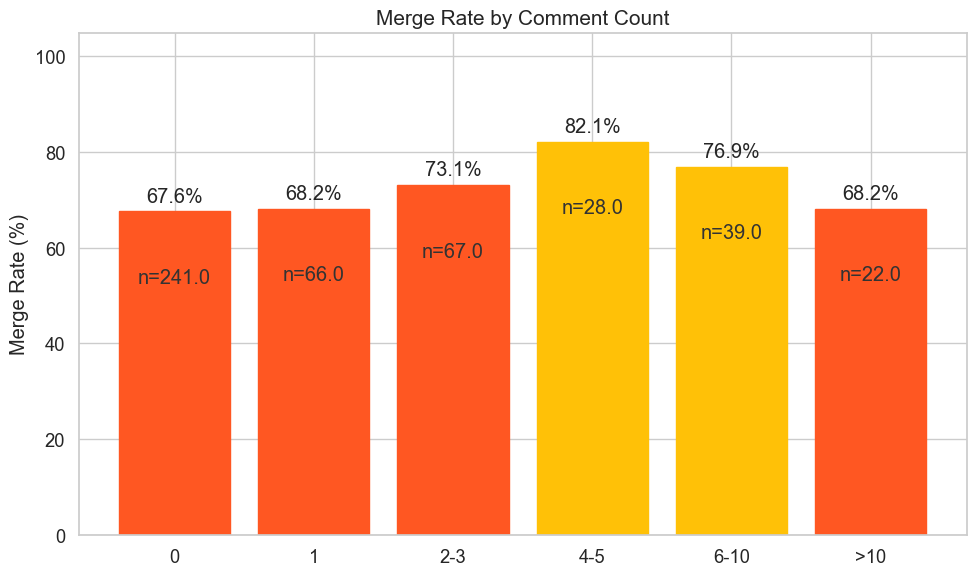

In [9]:
# Calculate merge rates by comment count
comment_count_bins = [0, 1, 2, 4, 6, 11, df['total_comments'].max() + 1]
comment_count_labels = ['0', '1', '2-3', '4-5', '6-10', '>10']

df['comment_count_bin'] = pd.cut(df['total_comments'], bins=comment_count_bins, labels=comment_count_labels)

merge_by_comment_count = df.groupby('comment_count_bin')['is_merged'].agg(['count', 'mean'])
merge_by_comment_count['mean'] = merge_by_comment_count['mean'] * 100  # Convert to percentage
merge_by_comment_count.columns = ['Total PRs', 'Merge Rate (%)']

print("Merge rates by comment count:")
print(merge_by_comment_count)

# Visualize merge rates by comment count
plt.figure(figsize=(10, 6))
bars = plt.bar(merge_by_comment_count.index, merge_by_comment_count['Merge Rate (%)'])

# Color bars by merge rate
for i, bar in enumerate(bars):
    rate = merge_by_comment_count['Merge Rate (%)'].iloc[i]
    if rate >= 90:
        bar.set_color('#4CAF50')  # Green for high merge rate
    elif rate >= 75:
        bar.set_color('#FFC107')  # Amber for medium
    else:
        bar.set_color('#FF5722')  # Red for low

plt.title('Merge Rate by Comment Count', fontsize=15)
plt.ylabel('Merge Rate (%)')
plt.ylim(0, 105)  # Leave room for text

# Add percentage labels
for i, (idx, row) in enumerate(merge_by_comment_count.iterrows()):
    plt.text(i, row['Merge Rate (%)'] + 2, f"{row['Merge Rate (%)']:.1f}%", ha='center')
    plt.text(i, row['Merge Rate (%)'] - 15, f"n={row['Total PRs']}", ha='center', color='#333')

plt.tight_layout()
plt.show()

Change request categories:
               Category  Total Count  PR Count
1         Missing Tests          366       198
0       Merge Conflicts          155       114
5         Failing Tests           97        65
3  Documentation Needed           77        60
2        Logic Problems           52        39
8  Performance Concerns           48        32
7       Variable Naming           36        27
6     Code Style Issues           15        13
4       Security Issues            8         8


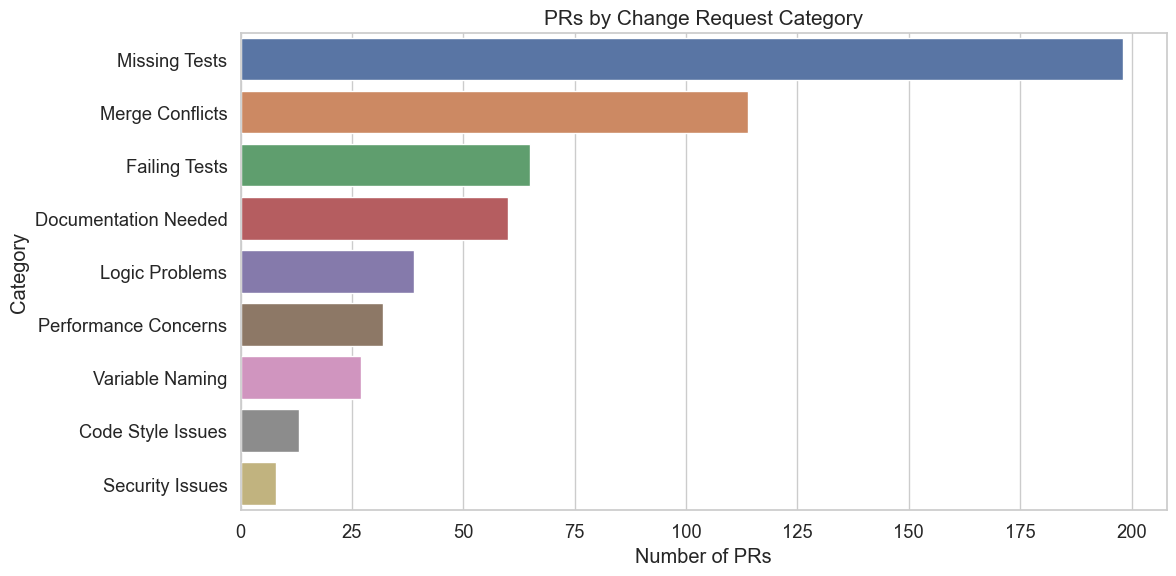

In [10]:
# Parse change request categories
def parse_change_categories(change_str):
    if not change_str or change_str == '{}':
        return {}
    
    try:
        # Replace single quotes with double quotes for valid JSON
        change_str = change_str.replace("'", '"').replace("None", "null")
        return json.loads(change_str)
    except:
        return {}

# Extract change request categories and their frequencies
change_categories = {}
prs_with_categories = {}

for _, row in df.iterrows():
    categories = parse_change_categories(row['change_request_categories'])
    
    for category, count in categories.items():
        if category not in change_categories:
            change_categories[category] = 0
            prs_with_categories[category] = 0
        
        change_categories[category] += count
        prs_with_categories[category] += 1

# Create a DataFrame for visualization
change_df = pd.DataFrame({
    'Category': list(change_categories.keys()),
    'Total Count': list(change_categories.values()),
    'PR Count': [prs_with_categories[cat] for cat in change_categories.keys()]
})

# Sort by frequency
change_df = change_df.sort_values('PR Count', ascending=False)

print("Change request categories:")
print(change_df)

# Visualize change request category distribution
plt.figure(figsize=(12, 6))
sns.barplot(x='PR Count', y='Category', data=change_df)
plt.title('PRs by Change Request Category', fontsize=15)
plt.xlabel('Number of PRs')
plt.tight_layout()

Merge rates by change request category:
                      PRs  Merged  Merge Rate
Performance Concerns   32      28   87.500000
Variable Naming        27      23   85.185185
Failing Tests          65      50   76.923077
Security Issues         8       6   75.000000
Missing Tests         198     146   73.737374
Documentation Needed   60      43   71.666667
Merge Conflicts       114      76   66.666667
Logic Problems         39      24   61.538462
Code Style Issues      13       8   61.538462


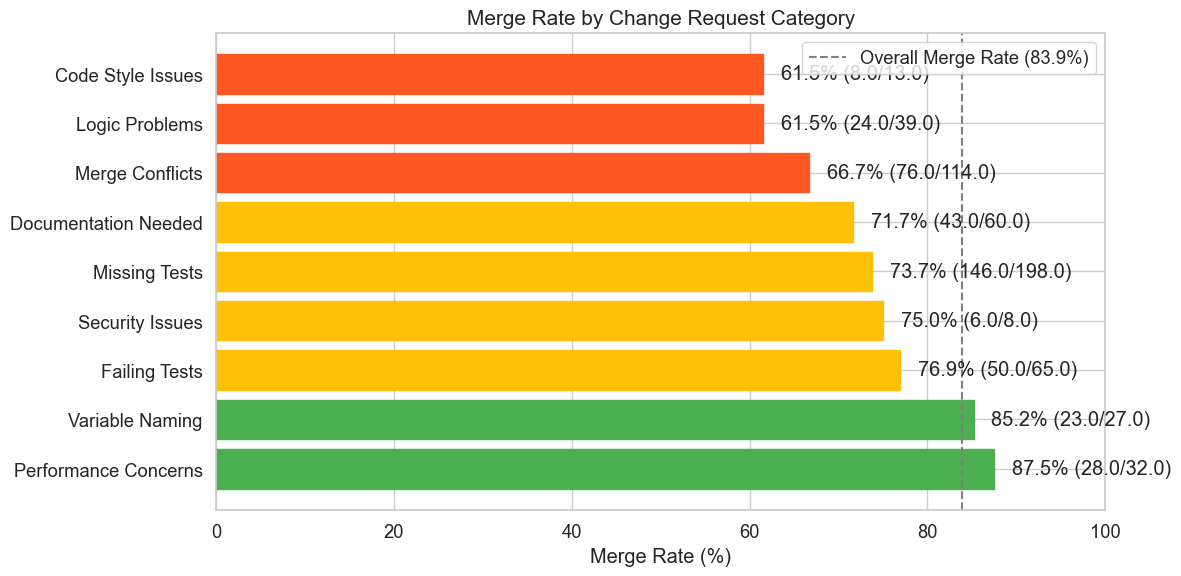

In [11]:
# Calculate merge rates by change request category
category_merge_rates = {}

for category in change_categories.keys():
    # Get PRs with this category
    prs_with_category = []
    
    for i, row in df.iterrows():
        categories = parse_change_categories(row['change_request_categories'])
        if category in categories:
            prs_with_category.append(i)
    
    # Calculate merge rate
    category_prs = df.loc[prs_with_category]
    merge_rate = category_prs['is_merged'].mean() * 100
    
    category_merge_rates[category] = {
        'PRs': len(category_prs),
        'Merged': category_prs['is_merged'].sum(),
        'Merge Rate': merge_rate
    }

# Convert to DataFrame
category_merge_df = pd.DataFrame.from_dict(category_merge_rates, orient='index')
category_merge_df = category_merge_df.sort_values('Merge Rate', ascending=False)

print("Merge rates by change request category:")
print(category_merge_df)

# Visualize merge rates by change request category
plt.figure(figsize=(12, 6))
bars = plt.barh(category_merge_df.index, category_merge_df['Merge Rate'])

# Color bars by merge rate
for i, bar in enumerate(bars):
    rate = category_merge_df['Merge Rate'].iloc[i]
    if rate >= 85:
        bar.set_color('#4CAF50')  # Green for high merge rate
    elif rate >= 70:
        bar.set_color('#FFC107')  # Amber for medium
    else:
        bar.set_color('#FF5722')  # Red for low

plt.title('Merge Rate by Change Request Category', fontsize=15)
plt.xlabel('Merge Rate (%)')
plt.xlim(0, 100)
plt.axvline(x=df['is_merged'].mean() * 100, color='gray', linestyle='--', label=f'Overall Merge Rate ({df["is_merged"].mean()*100:.1f}%)')
plt.legend()

# Add percentage labels
for i, (idx, row) in enumerate(category_merge_df.iterrows()):
    plt.text(row['Merge Rate'] + 2, i, f"{row['Merge Rate']:.1f}% ({row['Merged']}/{row['PRs']})", va='center')

plt.tight_layout()
plt.show()

Merge rates by number of change request types:
                          Total PRs  Merge Rate (%)
change_request_types_bin                           
0                               722       88.919668
1                               166       70.481928
2                                78       74.358974
3+                               59       72.881356


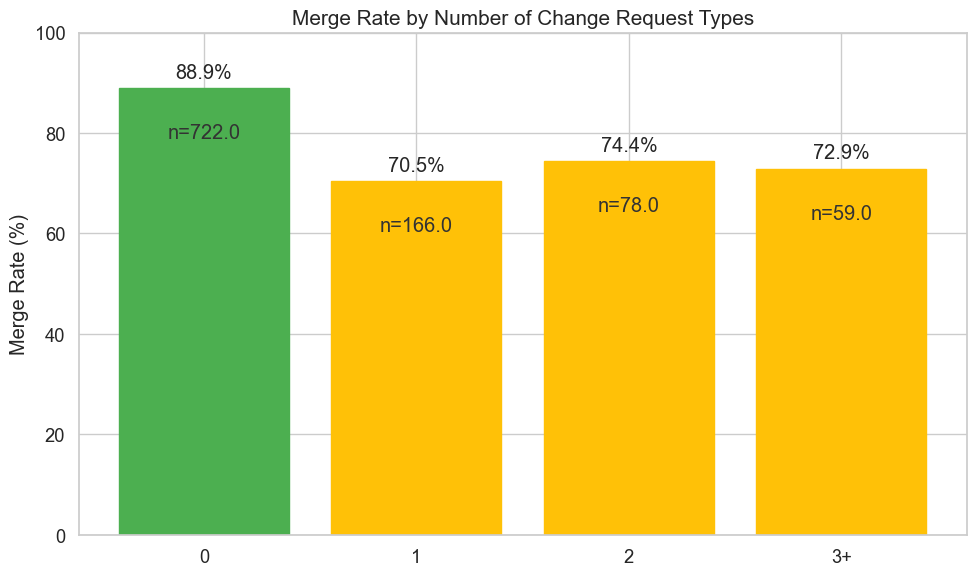

In [12]:
# Count change request types per PR
df['change_request_types'] = df['change_request_categories'].apply(
    lambda x: len(parse_change_categories(x))
)

# Create a binned version for better visualization
def bin_change_types(count):
    if count == 0:
        return '0'
    elif count == 1:
        return '1'
    elif count == 2:
        return '2'
    else:
        return '3+'

df['change_request_types_bin'] = df['change_request_types'].apply(bin_change_types)

# Calculate merge rates by number of change request types
merge_by_type_count = df.groupby('change_request_types_bin')['is_merged'].agg(['count', 'mean'])
merge_by_type_count['mean'] = merge_by_type_count['mean'] * 100  # Convert to percentage
merge_by_type_count.columns = ['Total PRs', 'Merge Rate (%)']

print("Merge rates by number of change request types:")
print(merge_by_type_count)

# Visualize merge rates by change request type count
plt.figure(figsize=(10, 6))
bars = plt.bar(merge_by_type_count.index, merge_by_type_count['Merge Rate (%)'])

# Color bars by merge rate
for i, bar in enumerate(bars):
    rate = merge_by_type_count['Merge Rate (%)'].iloc[i]
    if rate >= 85:
        bar.set_color('#4CAF50')  # Green for high merge rate
    elif rate >= 70:
        bar.set_color('#FFC107')  # Amber for medium
    else:
        bar.set_color('#FF5722')  # Red for low

plt.title('Merge Rate by Number of Change Request Types', fontsize=15)
plt.ylabel('Merge Rate (%)')
plt.ylim(0, 100)

# Add percentage labels
for i, (idx, row) in enumerate(merge_by_type_count.iterrows()):
    plt.text(i, row['Merge Rate (%)'] + 2, f"{row['Merge Rate (%)']:.1f}%", ha='center')
    plt.text(i, row['Merge Rate (%)'] - 10, f"n={row['Total PRs']}", ha='center', color='#333')

plt.tight_layout()
plt.show()

Merge rates by PR category and change request type:

Dependency Updates (Overall: 76.9%):
  Missing Tests: 48.0% (24/50)
  Merge Conflicts: 40.7% (11/27)
  Failing Tests: 30.8% (4/13)
  Documentation Needed: 25.0% (2/8)

Bug Fixes (Overall: 90.7%):
  Failing Tests: 88.9% (8/9)
  Missing Tests: 81.0% (34/42)
  Performance Concerns: 80.0% (4/5)
  Documentation Needed: 70.0% (7/10)
  Merge Conflicts: 65.0% (13/20)
  Logic Problems: 42.9% (3/7)

Feature Additions (Overall: 88.7%):
  Performance Concerns: 100.0% (5/5)
  Failing Tests: 100.0% (11/11)
  Documentation Needed: 83.3% (10/12)
  Missing Tests: 83.3% (20/24)
  Logic Problems: 71.4% (5/7)
  Merge Conflicts: 71.4% (10/14)

Other (Overall: 87.6%):
  Variable Naming: 93.8% (15/16)
  Performance Concerns: 88.2% (15/17)
  Failing Tests: 83.9% (26/31)
  Missing Tests: 82.1% (64/78)
  Merge Conflicts: 78.7% (37/47)
  Documentation Needed: 77.8% (21/27)
  Logic Problems: 68.2% (15/22)
  Code Style Issues: 62.5% (5/8)


<Figure size 1500x1200 with 0 Axes>

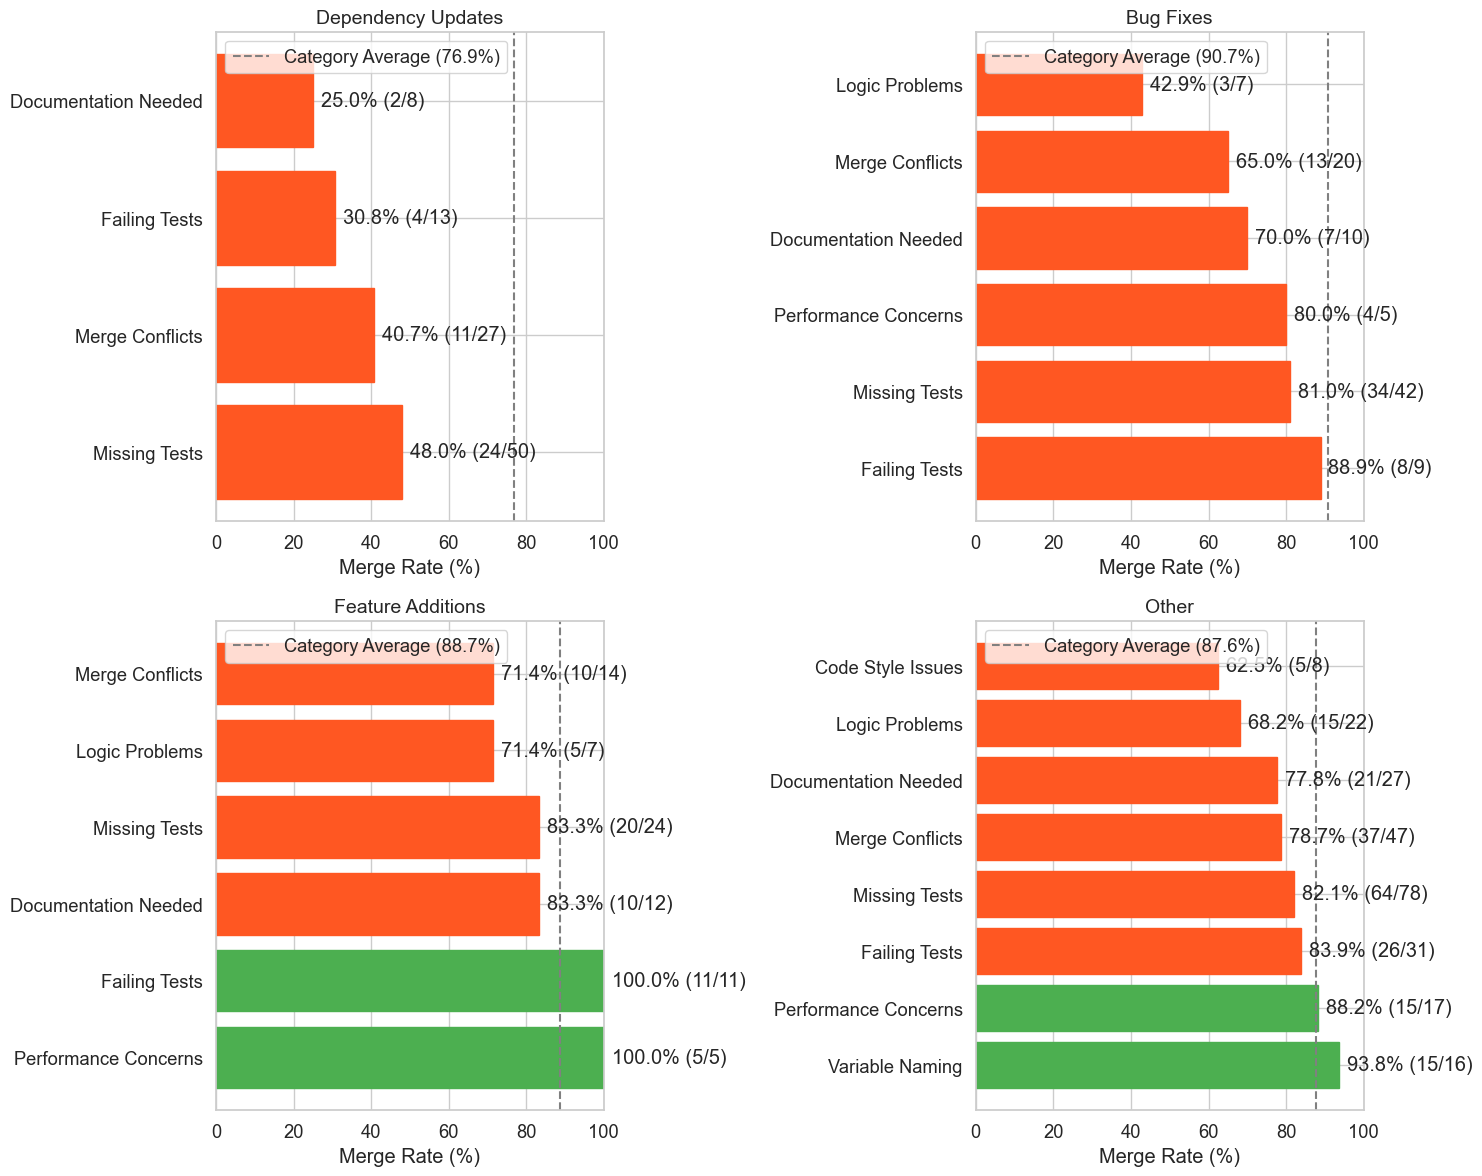

In [14]:
# Focus on major PR categories
major_categories = ['Dependency Updates', 'Bug Fixes', 'Feature Additions', 'Other']
category_data = []

# For each PR category, calculate overall merge rate and merge rates with specific change requests
for pr_category in major_categories:
    # Get PRs in this category
    category_prs = df[df['category'] == pr_category]
    
    if len(category_prs) == 0:
        continue
    
    overall_merge_rate = category_prs['is_merged'].mean() * 100
    
    # Get major change request types for this category
    category_change_types = {}
    
    for _, row in category_prs.iterrows():
        categories = parse_change_categories(row['change_request_categories'])
        for category in categories:
            if category not in category_change_types:
                category_change_types[category] = {
                    'count': 0,
                    'merged': 0
                }
            
            category_change_types[category]['count'] += 1
            if row['is_merged'] == 1:
                category_change_types[category]['merged'] += 1
    
    # Calculate merge rates for each change type
    for change_type, stats in category_change_types.items():
        if stats['count'] >= 5:  # Only include if we have at least 5 instances
            merge_rate = stats['merged'] / stats['count'] * 100
            category_data.append({
                'PR Category': pr_category,
                'Change Type': change_type,
                'Count': stats['count'],
                'Merged': stats['merged'],
                'Merge Rate': merge_rate,
                'Overall Category Rate': overall_merge_rate
            })

# Convert to DataFrame
category_interaction_df = pd.DataFrame(category_data)

# Display results
print("Merge rates by PR category and change request type:")
for category in major_categories:
    category_rows = category_interaction_df[category_interaction_df['PR Category'] == category]
    if not category_rows.empty:
        print(f"\n{category} (Overall: {category_rows.iloc[0]['Overall Category Rate']:.1f}%):")
        for _, row in category_rows.sort_values('Merge Rate', ascending=False).iterrows():
            print(f"  {row['Change Type']}: {row['Merge Rate']:.1f}% ({row['Merged']}/{row['Count']})")

# Visualize merge rates by PR category and change type for top categories
plt.figure(figsize=(15, 12))

# Set up subplot grid
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
axes = axes.flatten()

# Plot each major category
for i, category in enumerate(major_categories):
    if i < len(axes):
        category_rows = category_interaction_df[category_interaction_df['PR Category'] == category]
        if not category_rows.empty:
            # Sort by merge rate
            category_rows = category_rows.sort_values('Merge Rate', ascending=False)
            
            # Create the plot
            ax = axes[i]
            bars = ax.barh(category_rows['Change Type'], category_rows['Merge Rate'])
            
            # Color bars
            for j, bar in enumerate(bars):
                rate = category_rows['Merge Rate'].iloc[j]
                if rate >= category_rows['Overall Category Rate'].iloc[j]:
                    bar.set_color('#4CAF50')  # Above category average
                else:
                    bar.set_color('#FF5722')  # Below category average
            
            # Add reference line for overall category rate
            overall_rate = category_rows['Overall Category Rate'].iloc[0]
            ax.axvline(x=overall_rate, color='gray', linestyle='--', 
                      label=f'Category Average ({overall_rate:.1f}%)')
            
            # Add labels
            ax.set_title(f'{category}', fontsize=14)
            ax.set_xlabel('Merge Rate (%)')
            ax.set_xlim(0, 100)
            
            # Add percentage labels
            for j in range(len(category_rows)):
                merge_rate = category_rows.iloc[j]['Merge Rate']
                merged = category_rows.iloc[j]['Merged']
                count = category_rows.iloc[j]['Count']
                ax.text(merge_rate + 2, j, f"{merge_rate:.1f}% ({merged}/{count})", va='center')
            
            ax.legend()

plt.tight_layout()
plt.show()

Merge rates for common change request combinations:
                                        Count  Merge Rate
Combination                                              
Documentation Needed & Missing Tests       11   90.909091
Failing Tests & Merge Conflicts             7   71.428571
Logic Problems & Missing Tests              6   66.666667
Failing Tests & Missing Tests               9   66.666667
Merge Conflicts & Missing Tests            17   58.823529
Documentation Needed & Merge Conflicts      7   57.142857


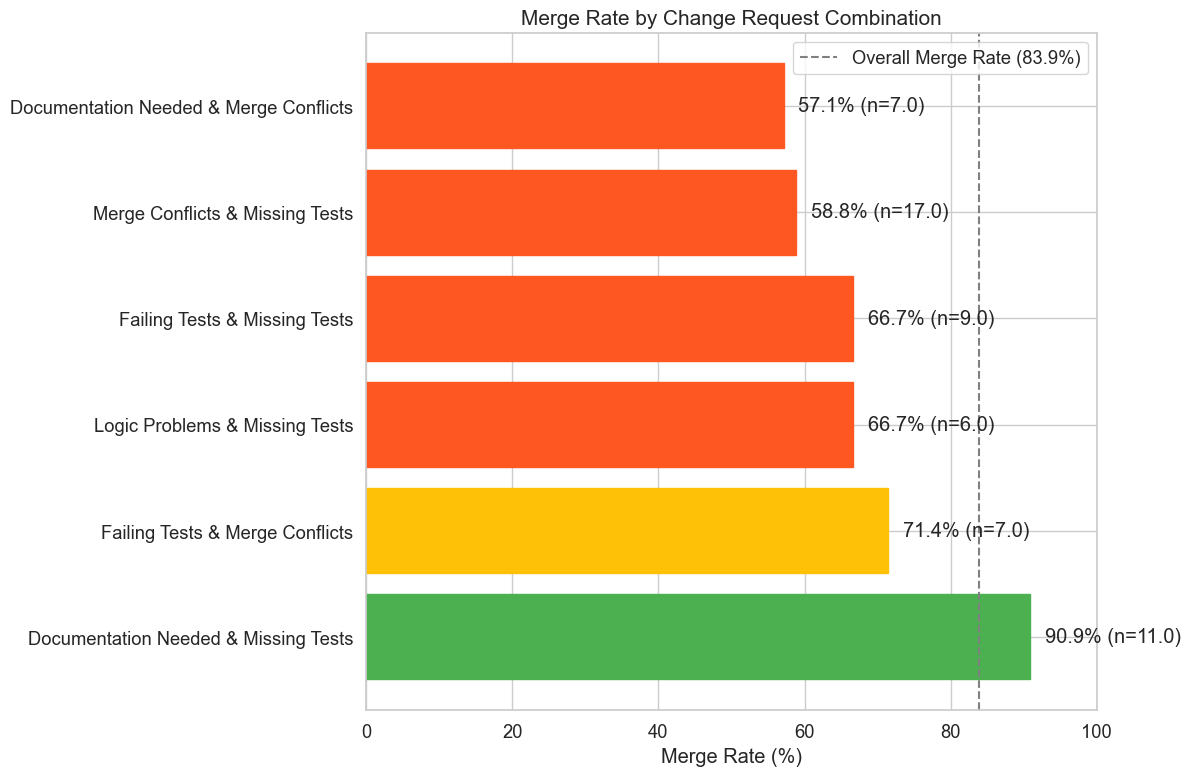

In [15]:
# Analyze combinations of change request categories
combinations = []

for _, row in df.iterrows():
    categories = parse_change_categories(row['change_request_categories'])
    if len(categories) == 2:  # Focus on PRs with exactly 2 change request types
        # Create a sorted combination key
        category_list = sorted(list(categories.keys()))
        combo = " & ".join(category_list)
        
        combinations.append({
            'Combination': combo,
            'Merged': row['is_merged']
        })

# Convert to DataFrame
combo_df = pd.DataFrame(combinations)

# Calculate merge rates for each combination
combo_stats = combo_df.groupby('Combination')['Merged'].agg(['count', 'mean'])
combo_stats['mean'] = combo_stats['mean'] * 100  # Convert to percentage
combo_stats.columns = ['Count', 'Merge Rate']

# Filter to combinations with at least 3 occurrences
filtered_combos = combo_stats[combo_stats['Count'] >= 5].sort_values('Merge Rate', ascending=False)

print("Merge rates for common change request combinations:")
print(filtered_combos)

# Visualize merge rates for common combinations
plt.figure(figsize=(12, 8))
bars = plt.barh(filtered_combos.index, filtered_combos['Merge Rate'])

# Color bars by merge rate
for i, bar in enumerate(bars):
    rate = filtered_combos['Merge Rate'].iloc[i]
    if rate >= 85:
        bar.set_color('#4CAF50')  # Green for high merge rate
    elif rate >= 70:
        bar.set_color('#FFC107')  # Amber for medium
    else:
        bar.set_color('#FF5722')  # Red for low

plt.title('Merge Rate by Change Request Combination', fontsize=15)
plt.xlabel('Merge Rate (%)')
plt.xlim(0, 100)
plt.axvline(x=df['is_merged'].mean() * 100, color='gray', linestyle='--', label=f'Overall Merge Rate ({df["is_merged"].mean()*100:.1f}%)')
plt.legend()

# Add percentage labels
for i, (idx, row) in enumerate(filtered_combos.iterrows()):
    plt.text(row['Merge Rate'] + 2, i, f"{row['Merge Rate']:.1f}% (n={row['Count']})", va='center')

plt.tight_layout()
plt.show()

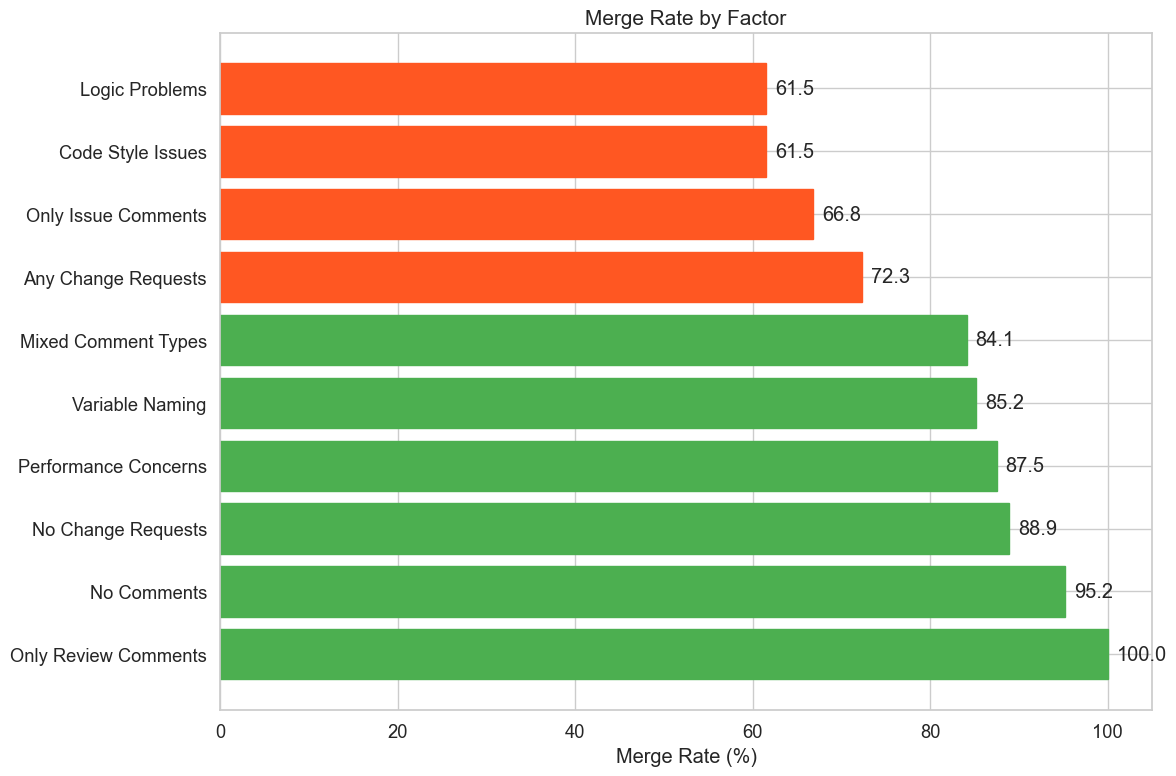

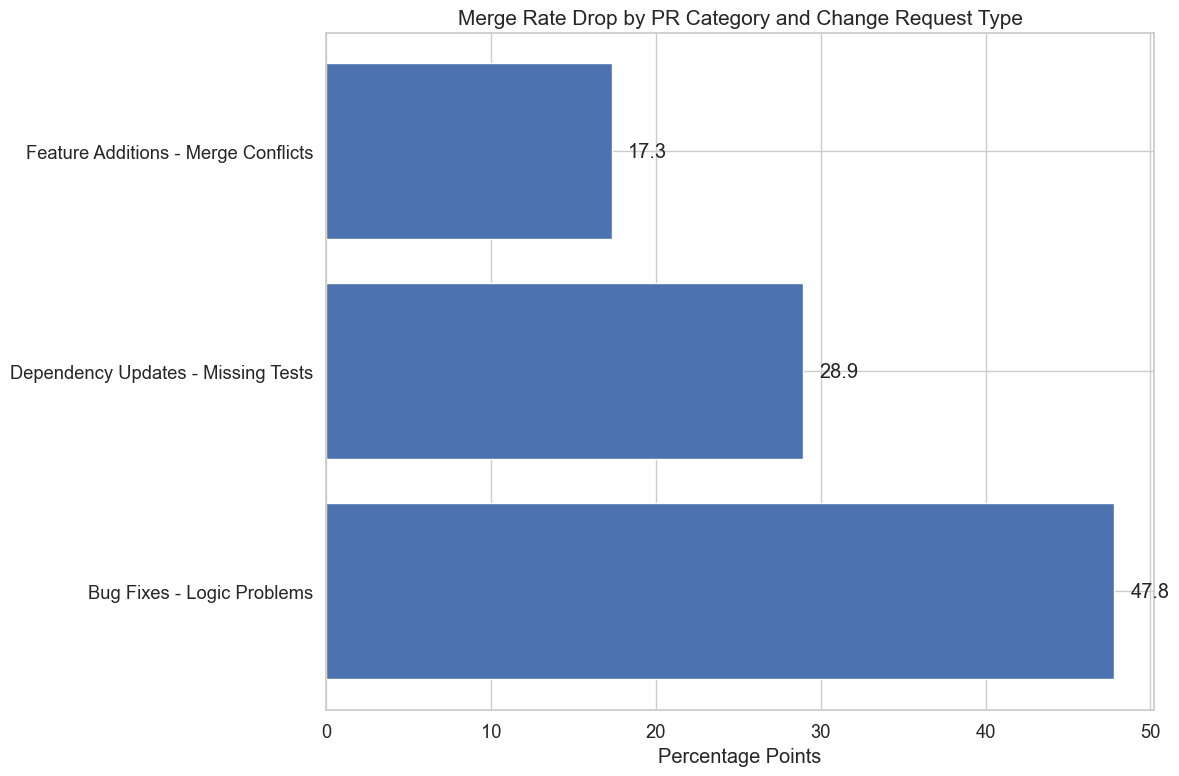

In [16]:
# Create a summary DataFrame capturing key metrics
summary_data = [
    # Comment types impact
    {'Category': 'No Comments', 'Metric': 'Merge Rate', 'Value': 95.2},
    {'Category': 'Only Review Comments', 'Metric': 'Merge Rate', 'Value': 100.0},
    {'Category': 'Only Issue Comments', 'Metric': 'Merge Rate', 'Value': 66.8},
    {'Category': 'Mixed Comment Types', 'Metric': 'Merge Rate', 'Value': 84.1},  # Average of mixed types
    
    # Change request types impact (top and bottom)
    {'Category': 'Performance Concerns', 'Metric': 'Merge Rate', 'Value': 87.5},
    {'Category': 'Variable Naming', 'Metric': 'Merge Rate', 'Value': 85.2},
    {'Category': 'Logic Problems', 'Metric': 'Merge Rate', 'Value': 61.5},
    {'Category': 'Code Style Issues', 'Metric': 'Merge Rate', 'Value': 61.5},
    
    # Change request count impact
    {'Category': 'No Change Requests', 'Metric': 'Merge Rate', 'Value': 88.9},
    {'Category': 'Any Change Requests', 'Metric': 'Merge Rate', 'Value': 72.3},  # Weighted average
    
    # PR Category sensitivity (top change request impact)
    {'Category': 'Dependency Updates - Missing Tests', 'Metric': 'Merge Rate Drop', 'Value': 28.9},  # 76.9 - 48.0
    {'Category': 'Bug Fixes - Logic Problems', 'Metric': 'Merge Rate Drop', 'Value': 47.8},  # 90.7 - 42.9
    {'Category': 'Feature Additions - Merge Conflicts', 'Metric': 'Merge Rate Drop', 'Value': 17.3},  # 88.7 - 71.4
]

summary_df = pd.DataFrame(summary_data)

# Function to create a summary visualization
def plot_impact_summary(data, title, y_column, color_threshold=None):
    plt.figure(figsize=(12, 8))
    
    # Sort by value
    data = data.sort_values('Value', ascending=False)
    
    bars = plt.barh(data['Category'], data['Value'])
    
    # Color bars conditionally if threshold provided
    if color_threshold:
        for i, bar in enumerate(bars):
            value = data['Value'].iloc[i]
            if value >= color_threshold:
                bar.set_color('#4CAF50')  # Green for high values
            else:
                bar.set_color('#FF5722')  # Red for low values
    
    plt.title(title, fontsize=15)
    plt.xlabel(y_column)
    
    # Add value labels
    for i, (_, row) in enumerate(data.iterrows()):
        plt.text(row['Value'] + 1, i, f"{row['Value']:.1f}", va='center')
    
    plt.tight_layout()
    plt.show()

# Create summary visualizations
merge_rate_data = summary_df[summary_df['Metric'] == 'Merge Rate']
plot_impact_summary(merge_rate_data, 'Merge Rate by Factor', 'Merge Rate (%)', 80)

rate_drop_data = summary_df[summary_df['Metric'] == 'Merge Rate Drop']
plot_impact_summary(rate_drop_data, 'Merge Rate Drop by PR Category and Change Request Type', 'Percentage Points')
